In [1]:
# Import libraries
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

In [2]:
# For plot to appear in the notebook
%matplotlib inline 

# Import initial data

In [3]:
# Set the path to the original shapefile - Please adapt the path to your own data
admin1_shape="/media/tais/data/Dropbox/ULB/MAUPP/Coordination collaborateurs sur place/WP6_populeation_limitesadmin/Dakar_StLouis/Dakar_admin5_topological_clean/Dakar_units_core_cleaned.shp"
# Read the shapefile
gdf1 = gpd.read_file(admin1_shape)

In [4]:
# Keep only columns with population data (quantitative) that could be aggregated using a "grouby - sum" function
# Please adapt the column names according to your own data - Be carefull to keep the geometry column
gdf1 = gdf1.loc[:,['geometry','CONCESSION','MENAGE', 'HOMME', 'FEMME', 'POPULATION']] 

In [5]:
# Display the attribute table
gdf1.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493


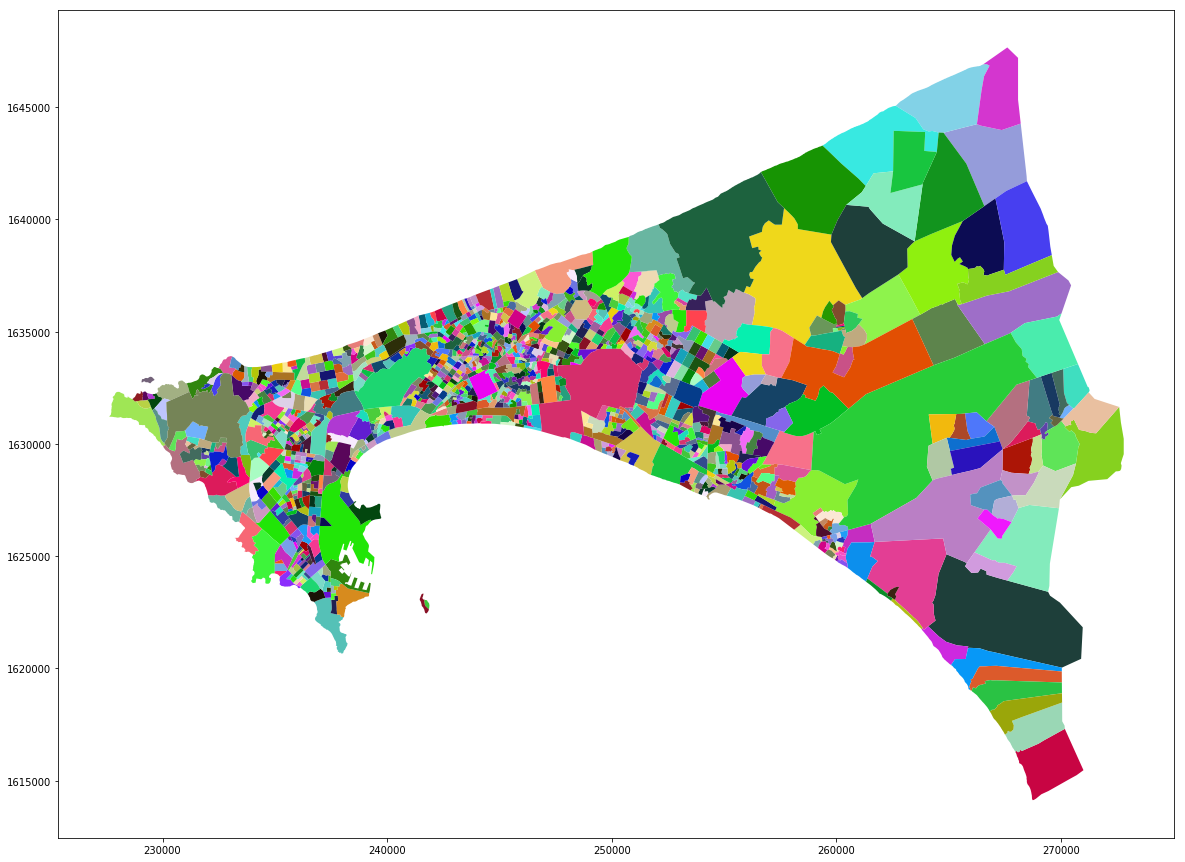

In [6]:
# A random colormap for matplotlib
cmap = mpl.colors.ListedColormap(np.random.rand(256,3))
# Display + Save figure
gdf1.plot(cmap=cmap, figsize=(20,20))
plt.savefig("Illustrations/original_admin1.png", dpi=300, bbox_inches='tight')

# Kmeans clustering

In [7]:
def add_xy_columns(gdf1):
    # Add two columns to the attribute table with x (long) and y (lat)
    gdf1["x"] = gdf1.centroid.map(lambda p: p.x)
    gdf1["y"] = gdf1.centroid.map(lambda p: p.y)

In [8]:
def kmeans_on_geom_centroid(gdf, n_clusters, n_jobs=3):
# n_clusters : number of desired clusters resulting from the initial Kmeans (int) 
# n_jobs : number of cores (processes) to use for the kmeans (int) 
    if n_clusters < len(gdf):
        # Getting the x/y values
        f1 = gdf['x'].values
        f2 = gdf['y'].values
        X = np.array(list(zip(f1, f2)))
        # Run Kmeans clustering
        kmeans = KMeans(n_clusters=n_clusters, n_jobs=n_jobs).fit(X) 
        labels = kmeans.predict(X) # Getting the cluster labels
        # Joint results to the attribute table
        gdf["cluster"] = labels        
    else:
        print "The desired number of clusters from Kmeans is bigger or equal to the number of initial units.\nPlease reduce the value of 'n_clusters' parameter bellow %s."%(len(gdf)-1)

In [9]:
add_xy_columns(gdf1) # Add XY coordinates of the polygon centroid
kmeans_on_geom_centroid(gdf1, n_clusters=300, n_jobs=15) # Perform Kmeans clustering on XY columns
gdf1.head() # Display the attribute table

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,x,y,cluster
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,250415.671612,1.629636e+06,44
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120,249673.014011,1.629686e+06,44
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050,249951.172254,1.629563e+06,44
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958,249989.434381,1.629923e+06,44
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493,249696.999188,1.629966e+06,266


# Dissolve admin1 level to get admin0 level

In [10]:
def dissolve_admin1_to_admin0(gdf1):
    # Use dissolve function of Geopandas
    gdf0 = gdf1.dissolve(by='cluster', aggfunc='sum', as_index=False)
    gdf0.drop(['x', 'y'], axis=1, inplace=True) # Drop 'x' and 'y' columns since their sum do not have sense
    # Add count of admin1 unit in each cluster
    count_units = gdf1.dissolve(by='cluster', aggfunc='count', as_index=False)['x']
    gdf0['count'] = count_units
    return gdf0

In [11]:
# Dissolve admin1 level accordint to 'cluster' column to get admin0
gdf0 = dissolve_admin1_to_admin0(gdf1)
# Display the attribute table
gdf0.head()

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,count
0,0,"POLYGON ((245758.1602999996 1632283.884400001,...",987,2380,8541,8099,16639,7
1,1,"POLYGON ((255324.7094999999 1628040.3201, 2551...",766,1390,5195,5538,10734,7
2,2,"POLYGON ((235555.1446000002 1630414.092700001,...",1311,3039,7782,8253,16038,12
3,3,(POLYGON ((269386.2112999996 1630574.949200001...,370,533,2532,2638,5169,3
4,4,(POLYGON ((249576.0542000001 1634790.633400001...,683,1032,3527,3811,7338,4


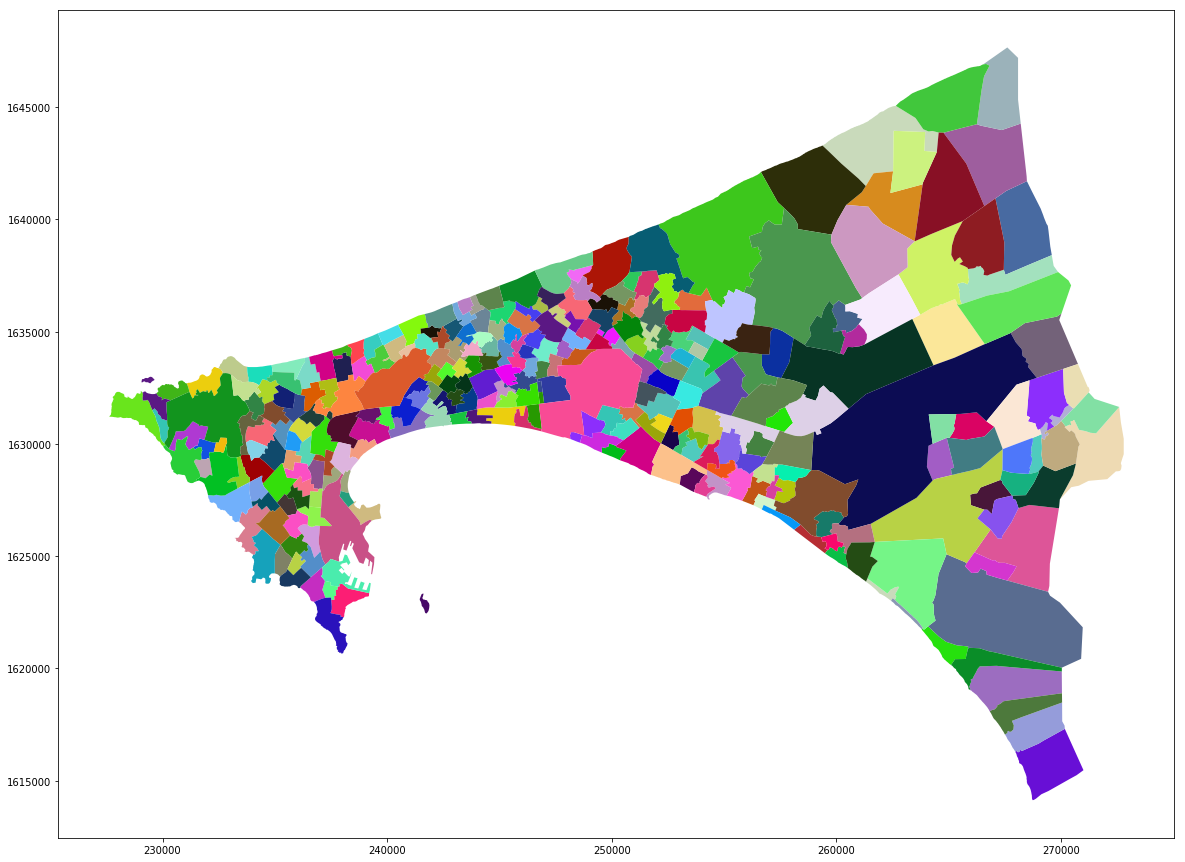

In [12]:
# Display + Save figure
gdf0.plot(column='cluster', cmap=cmap, figsize=(20, 20))
plt.savefig("Illustrations/admin0_initial_kmeans_results.png", dpi=300, bbox_inches='tight')

# Improve the initial clustering

## Check if cluster members are disjoint from each other

In [13]:
def fix_disjoint_(gdf):
    ## Create a list of unique cluster values (sorted)
    cluster_list = list(gdf.cluster)
    cluster_list.sort()
    cluster_list = list(set(cluster_list)) # Use 'set' to get unique values

    ## Iterate through cluster list 
    found = False
    for cluster in cluster_list:
        a=gdf.loc[gdf1["cluster"]==cluster] # Create a temporary dataframe with units belong to the current cluster
        if len(a) > 1:  # Only continue if there are at least 2 rows in the dataframe
            for index, row in a.iterrows():
                geom_a = row.geometry  # Geometry of the current unit
                other_geom = a[~a.index.isin([index])].geometry # Geometry of the other units belonging to the cluster
                disconected_unit = other_geom.disjoint(geom_a).all() # Return True if all element of the pandas serie are True (all disconect)
                if disconected_unit:
                    found = True
                    new_cluster = gdf.cluster.max()+1
                    gdf.at[index, "cluster"] = new_cluster   # Assign new cluster value
                    print "Cluster %s had one unit disconected from the others that has been assign to new cluster (%s)"%(row.cluster,new_cluster)
    if not found:
        print "No problem found regarding to disjoint cluster members."

In [14]:
## Check and fix for issue of disjointed cluster members in the initial Kmeans results
fix_disjoint_(gdf1)

Cluster 3 had one unit disconected from the others that has been assign to new cluster (300)
Cluster 4 had one unit disconected from the others that has been assign to new cluster (301)
Cluster 76 had one unit disconected from the others that has been assign to new cluster (302)
Cluster 150 had one unit disconected from the others that has been assign to new cluster (303)
Cluster 221 had one unit disconected from the others that has been assign to new cluster (304)
Cluster 243 had one unit disconected from the others that has been assign to new cluster (305)


## Fix issues of clusters compouned by 1 unit only

The strategy implemented here is to merge 1unit-clusters with its neighboring cluster that is compouned by the smallest number of iriginal administratives units.

In [15]:
# Declare a function that check how many cluster are composed of only have one unit 
def check_remaining_single_cluster(df):
    global count_dict
    count_dict={x.cluster:x['count'] for i,x in df.iterrows()}
    number_single_cluster = len(df.loc[df['count']<2])
    return number_single_cluster

In [16]:
# Declare a function that add a "NEIGHBORS" column with id of neighboring clusters 
def find_neighbors(gdf, unique_id="cluster"):
    gdf["NEIGHBORS"] = None  # Add empty NEIGHBORS column
    for index, unit in gdf.iterrows():   
        # get 'not disjoint' countries
        neighbors = gdf[~gdf.geometry.disjoint(unit.geometry)][unique_id].tolist()
        if len(neighbors)==1:
            # Get the geom of the centroid of origin (the current row) and of the destination (all the other points)
            origin_geom = gdf0.iloc[index].geometry.centroid
            destin_geom = gdf0[~gdf0.index.isin([index])].geometry.centroid
            tmp_df = pd.DataFrame(gdf0.loc[:,"cluster"])
            dist_min = pd.DataFrame(destin_geom.geometry.distance(origin_geom))
            tmp_df['dist']=dist_min
            nearest_cluster = int(tmp_df.loc[tmp_df['dist']==float(tmp_df['dist'].min())]['cluster'])
            neighbors = [nearest_cluster]
        # remove own name from the list
        neighbors = [str(Id) for Id in neighbors if unit[unique_id] != Id]
        # add names of neighbors as NEIGHBORS value
        gdf.at[index, "NEIGHBORS"] = ", ".join(neighbors)

In [17]:
# Declare a function that return the id of the smallest neighborhing cluster 
def check_smallest_cluster(_dict, _list):
        neighbor_id=[int(x) for x in _list.split(',')]
        candidate_value=_dict[neighbor_id[0]]
        candidate_id=neighbor_id[0]
        for x in neighbor_id[1:]:
            if _dict[x] < candidate_value:
                candidate_value=_dict[x]
                candidate_id=x
        return candidate_id

In [18]:
find_neighbors(gdf0) # Add/update the list of neighbors of each cluster
gdf0.head() # Display the attribute table

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,count,NEIGHBORS
0,0,"POLYGON ((245758.1602999996 1632283.884400001,...",987,2380,8541,8099,16639,7,"98, 114, 161, 189, 255, 282"
1,1,"POLYGON ((255324.7094999999 1628040.3201, 2551...",766,1390,5195,5538,10734,7,"101, 176, 183, 198, 205"
2,2,"POLYGON ((235555.1446000002 1630414.092700001,...",1311,3039,7782,8253,16038,12,"54, 84, 97, 111, 186, 223"
3,3,(POLYGON ((269386.2112999996 1630574.949200001...,370,533,2532,2638,5169,3,"69, 77, 163, 197, 225, 237"
4,4,(POLYGON ((249576.0542000001 1634790.633400001...,683,1032,3527,3811,7338,4,"118, 172, 238, 265, 283"


In [19]:
## Minimum original units per cluster
# Please adapt this value with the minimum number of original units you desire in the final clusters
# Please consider a reasonable and judicious number, according to the context of your data
min_units = 4

## As long as there remain issues (clusters with only one admin unit) merge it with the neighboring cluster that have the smallest number of admin units
current_number_clusters = len(gdf0)
remaining = check_remaining_single_cluster(gdf0)  # remaining variable takes number of cluster remaining with only 1 original unit
if remaining == 0:
    print "The admin 1 layer contains %s clusters."%current_number_clusters
    print "Nothing to fix: All clusters are compouned by at least %s original administrative units"%min_units
else:
    print "Fixing issue(s)..."
    while remaining > 0:
        for index, unit in gdf0.iterrows():   
            if unit['count'] < min_units:
                list_neighbors=unit.NEIGHBORS
                candidate_cluster=check_smallest_cluster(count_dict,list_neighbors)
                print "   -> cluster %s only have 1 original unit and will be merge with cluster %s"%(unit['cluster'],candidate_cluster)
                # Update the value of 'cluster' column (result of Kmeans) with the new candidate cluster
                gdf1['cluster'] = gdf1.cluster.apply(lambda x: candidate_cluster if x == unit['cluster'] else x)  
                break  # Allow to operate dissolving one by one
        # Dissolve according to the updated cluster membership
        gdf0 = dissolve_admin1_to_admin0(gdf1)
        find_neighbors(gdf0)
        remaining = check_remaining_single_cluster(gdf0)
        print 'remaining issues : %s'%remaining
    current_number_clusters = len(gdf0)
    print "\n**-_-_-_-_-_-_-_-_-_-_-_-_-_-_**"
    print "\nThe admin 1 layer contains %s clusters."%current_number_clusters
    print "\nAll issues have been removed: All clusters are compouned by at least %s original administrative units"%min_units    

Fixing issue(s)...
   -> cluster 3 only have 1 original unit and will be merge with cluster 69
remaining issues : 76
   -> cluster 4 only have 1 original unit and will be merge with cluster 172
remaining issues : 76
   -> cluster 6 only have 1 original unit and will be merge with cluster 220
remaining issues : 75
   -> cluster 7 only have 1 original unit and will be merge with cluster 59
remaining issues : 73
   -> cluster 15 only have 1 original unit and will be merge with cluster 267
remaining issues : 72
   -> cluster 17 only have 1 original unit and will be merge with cluster 202
remaining issues : 71
   -> cluster 20 only have 1 original unit and will be merge with cluster 303
remaining issues : 70
   -> cluster 22 only have 1 original unit and will be merge with cluster 51
remaining issues : 68
   -> cluster 25 only have 1 original unit and will be merge with cluster 104
remaining issues : 67
   -> cluster 27 only have 1 original unit and will be merge with cluster 139
remaining 

remaining issues : 5
   -> cluster 246 only have 1 original unit and will be merge with cluster 135
remaining issues : 5
   -> cluster 252 only have 1 original unit and will be merge with cluster 248
remaining issues : 5
   -> cluster 264 only have 1 original unit and will be merge with cluster 288
remaining issues : 5
   -> cluster 274 only have 1 original unit and will be merge with cluster 285
remaining issues : 5
   -> cluster 286 only have 1 original unit and will be merge with cluster 256
remaining issues : 5
   -> cluster 290 only have 1 original unit and will be merge with cluster 104
remaining issues : 5
   -> cluster 292 only have 1 original unit and will be merge with cluster 47
remaining issues : 5
   -> cluster 294 only have 1 original unit and will be merge with cluster 149
remaining issues : 5
   -> cluster 296 only have 1 original unit and will be merge with cluster 143
remaining issues : 5
   -> cluster 297 only have 1 original unit and will be merge with cluster 179
r

## Display final result - Admin 0 borders

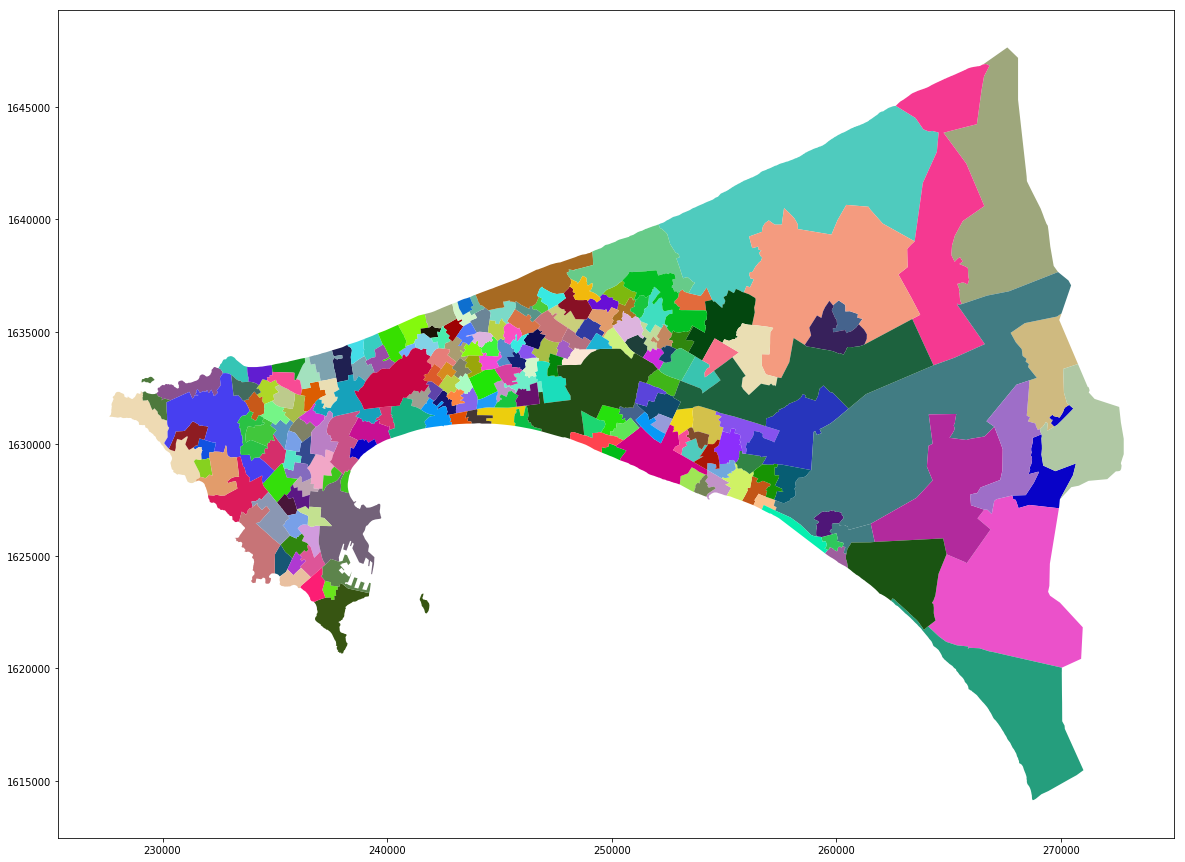

In [20]:
# Display + Save figure
gdf0.plot(column='cluster', cmap=cmap, figsize=(20, 20))
plt.savefig("Illustrations/newly_created_admin0.png", dpi=300, bbox_inches='tight')

# Export admin0 shapefile

In [21]:
# Set the path to the shapefile to be created
shape_export = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0.shp'
# Export
gdf0.to_file(driver='ESRI Shapefile',filename=shape_export)

# Plot distribution of number of initial units per cluster

In [22]:
# Get a list with count values
x = list(gdf0['count'])

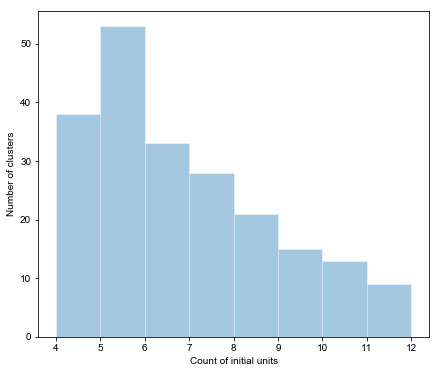

In [23]:
# Plot the distribution
nbins=max(x)-min_units
plt.figure(figsize=(7,6))
#plt.title('Number of original unit',fontdict={'fontsize': 15})
plt.ylabel("Number of clusters")
plt.xlabel("Count of initial units")
sns.set_style("darkgrid")
sns.set_context("paper")
sns.distplot(x, bins=nbins, kde=False)
plt.savefig("Illustrations/distribution.png", dpi=300, bbox_inches='tight')